In [1]:
import os
# https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html#
#https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quickstart.html
from ipywidgets import FloatProgress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

#### ftns

In [2]:
#https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_session.html#Stimulus-presentations
from itertools import product
def get_spike_trains(my_units, STIM_CLASS, PARAM_NAMES, prestim_len, bin_size):
    
    trials_info = session.get_stimulus_table(STIM_CLASS)
    
    if trials_info.index.size == 0:
        return {}

    trial_len = round(np.mean(trials_info['duration'].values),2) #sec
    print('trial_len',trial_len)
    tot_len = trial_len + prestim_len
    
    time_bin_edges = np.linspace(-prestim_len, trial_len, int(tot_len/bin_size))
    NBINS = len(time_bin_edges)-1
    
    binarize = False
    if bin_size < .001:
        binarize = True

    print('NBINS',NBINS)

    # look at responses to a certain type of gratings
    stim_params = {pname:sorted(set(trials_info[pname].unique()).difference(['null'])) for pname in PARAM_NAMES}
    print(f'{STIM_CLASS} params:', stim_params)
    
    #get all param combinations
    paramvals_tuples = list(product(*[stim_params[pname] for pname in PARAM_NAMES]))

    all_trains = {}
    for ii,ui in enumerate(my_units):
        print('.',end=' ')
        all_trains[ui] = {}
        
        for pvals_tup in paramvals_tuples:
            row_filter = np.prod(np.stack([trials_info[pname].values == pval for pname,pval in zip(PARAM_NAMES,pvals_tup)],axis=0),axis=0).astype('bool')

            sids = trials_info[row_filter].index.values
            Ntrials = len(sids)
#             print(f'{pvals_tup}, {Ntrials=}')

            #TODO compare speed against reading spk times directly: https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_optotagging.html
            spike_counts_da = session.presentationwise_spike_counts(
                bin_edges=time_bin_edges,
                stimulus_presentation_ids=sids,
                unit_ids=[ui],
                binarize=binarize
            )
            spike_counts_da = np.squeeze(spike_counts_da.values)
        
#             print(spike_counts_da.shape,spike_counts_da.max(),spike_counts_da.sum())
            #re-convert to spike times

            unit_trains = []
            for triali in range(Ntrials):
                train = np.flatnonzero(spike_counts_da[triali]).astype('float32')
                unit_trains.append(train * bin_size * 1000) #convert bin number to time (ms)
            all_trains[ui][pvals_tup] = unit_trains
    print()
    return all_trains



def get_train_dicts(all_trains_uid, tf, dirs, trial_len_ms, prestim_len_ms):
    trials_traindict = {}
    ISI_Nspks = {}
    full_traindict = {}
    for d in dirs:
        ptup = (tf, d,)
        assert ptup in all_trains_uid

        ISI_Nspks[d] = []
        new_trains = []
        for train in all_trains_uid[ptup]:
            if len(train) == 0:
                new_trains.append(np.array([]))
                ISI_Nspks[d].append(0)
                continue
            assert max(train) < trial_len_ms + prestim_len_ms


            new_train = train - prestim_len_ms

            new_trains.append(new_train[new_train >= 0])
            ISI_Nspks[d].append(new_train[new_train < 0].size)

        trials_traindict[d] = new_trains
        ISI_Nspks[d] = np.asarray(ISI_Nspks[d])
        full_traindict[d] = all_trains_uid[ptup]
    return full_traindict, trials_traindict, ISI_Nspks

import scipy as sp
import warnings
def computeResponseStats(traindict, ISI_Nspks, stats_ISI_len, trial_len, verbose=False):
    
    """Runs statistical tests to compare firing rates between the ISI and a given stimulus,
    for any period within the stimulus trial with the same length as the ISI.
    It performs two comparisons against the ISI FR: one using the maximum FR found for that 
    interval length across stimulus trials; and another using the minimum FR.
    
    The following one-sided tests are run:
    Mann-Whitney U
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
    
    and Wilcoxon:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
    
    ----------------
    Arguments:
    traindict: dict, {stimulus_direction: list of spike time arrays (ms), one per trial}
    ISI_Nspks: dict, {stimulus_direction: list of spike counts, one per trial}
    stats_ISI_len: float, length of the ISI interval, in secs, used to compute ISI_Nspks
    trial_len: float, total length of each trial, in secs
    
    ----------------
    Returns:
    stats_results: dict, for each of 'min-interval' and 'max-interval', contains a dict
     containing, for each stimulus direction, the p-values found for each tests, as well
     as the FRs for the stimulus and the ISI 
    """
    mydirs = traindict.keys()
    stats_results = {}

    interval_Nspks_for_stats = {'min':{}, 'max':{}}
    for d in mydirs:
    
        #combine all trains
        data = np.concatenate(traindict[d])
        counts,bins = np.histogram(data,np.arange(0,trial_len+stats_ISI_len,stats_ISI_len))

        maxfr = -1
        minfr = np.inf
        for i in range(0,counts.size):
            fr = counts[i]
            if fr > maxfr:
                maxi = i
                maxfr = fr
            if fr < minfr:
                mini = i
                minfr = fr


        for interval_type,i_,fr_ in [('min',mini,minfr), ('max',maxi,maxfr)]:

            interval_Nspks_for_stats[interval_type][d] = []

            for train in traindict[d]:
                spks_within_interval = train[(train >= stats_ISI_len*i_) & (train < stats_ISI_len*(i_+1))]
                interval_Nspks_for_stats[interval_type][d].append( spks_within_interval.size )

            interval_Nspks_for_stats[interval_type][d] = np.array(interval_Nspks_for_stats[interval_type][d])
#             print(d,interval_type,interval_Nspks_for_stats[interval_type][d])
            assert len(interval_Nspks_for_stats[interval_type][d]) == len(traindict[d])
            assert interval_Nspks_for_stats[interval_type][d].sum() == fr_


    for trial_Nspks_for_stats_,pval_type,alternative in [
                                           (interval_Nspks_for_stats['max'],'maxinterval-pval','greater'),
                                           (interval_Nspks_for_stats['min'],'mininterval-pval','less')]:
        stats_results[pval_type] = {}
        

        for d in mydirs:
            dir_grayspks = ISI_Nspks[d]
            dir_stimspks = trial_Nspks_for_stats_[d]
            assert len(dir_stimspks) == len(dir_grayspks)
            if len(dir_stimspks) * len(dir_grayspks) == 0:
                stats_results[pval_type][d] = (np.inf,0,0)
                stats_results[pval_type][d] = {'MANNWHITNEY':np.inf,'WILCOXON':np.inf,'isiFR':0,'stimFR':0}
                if verbose: print(f'{d} no spikes')
                continue

            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore",category=RuntimeWarning)
                    _, pval = sp.stats.mannwhitneyu(dir_stimspks, dir_grayspks, alternative=alternative)
            except:                 
                pval = np.inf

            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore",category=RuntimeWarning)
                    warnings.simplefilter("ignore",category=UserWarning)
                    _, wpval = sp.stats.wilcoxon(dir_stimspks, dir_grayspks, alternative=alternative)
            except:
                wpval = np.inf


            stats_results[pval_type][d] = {'MANNWHITNEY':pval,'WILCOXON':wpval,'isiFR':dir_grayspks.mean()/stats_ISI_len,'stimFR':dir_stimspks.mean()/stats_ISI_len}
            if verbose: print(f'{d} {pval_type} ({pval:.3f},{wpval:.3f}), gray={dir_grayspks.mean()/stats_ISI_len:.2f}, stim={dir_stimspks.mean()/stats_ISI_len:.2f}')
    
    return stats_results

from KDEpy import FFTKDE
def getResponseCurve(train_dict, total_trial_len, bw=None, samp_interval=1, MINBW=10, MAXBW=50):

    """Computes smooth trial-averaged response to a stim in all directions from spike trains
    using a kernel density estimator."""
    
    ts = np.arange(0,total_trial_len+samp_interval,samp_interval)
    x_ts = .5*(ts[:-1]+ts[1:]) #sample at the midpoints between sampling intervals

    all_ISJs = []
    
    
    fftkde = None
    if bw is None:
        # if no pre-specified kernel bandwidth, 
        #  auto-estimate within range [MINBW, MAXBW]
        bw, fftkde = fitSmoothingKernelBandwidth(train_dict, total_trial_len)
        if bw is not None:
            bw = max(min(MAXBW,bw),MINBW)
            fftkde.bw = bw
        else:
            bw = MAXBW

    for di,d in enumerate(sorted(train_dict)):

        full_train = []
        for triali,train in enumerate(train_dict[d]):
            if train.size == 0: continue
            assert max(train) < total_trial_len
            full_train += list(train)    

        data = np.array(full_train)
        data.sort()
        n = data.size
        if fftkde is None:
            fftkde = FFTKDE(kernel='gaussian', bw=bw) #initialize kernel density estimator

        try:
            fftkde = fftkde.fit(data)
            #extend sampling one unit before and after trial
            ext_x_ts = np.r_[x_ts[0]-samp_interval,x_ts,x_ts[-1]+samp_interval]
            #then crop after applying the kernel
            y = fftkde.evaluate(ext_x_ts)[1:-1]

        except:
            #error occurs in the rare cases when there are zero spikes. print out to double-check
            # print(f'fftkde failed: {n} data points')
            y = np.zeros_like(x_ts)


        all_ISJs.append(y*n*1000/len(train_dict[d])) #convert density to spks/sec
    return np.array(all_ISJs), x_ts

def fitSmoothingKernelBandwidth(full_traindict, total_trial_len):
    """Fits a spike smoothing kernel to spike train data using 
    the improved Sheather-Jones (ISJ) algorithm:
    
    Z. I. Botev, J. F. Grotowski, and D. P. Kroese.
    “Kernel density estimation via diffusion.” 
    Annals of Statistics, Volume 38, Number 5, pp. 2916-2957, 2010.
    https://arxiv.org/pdf/1011.2602.pdf
    
    (see https://kdepy.readthedocs.io/en/latest/index.html 
    for more information on this implementation)
    
    
    ---------------
    Arguments:
    full_traindict: dict, {stimulus_direction: list of spike time arrays, one per trial}
    The bandwidth is computed for the stimulus direction that elicited the most spikes.
    total_trial_len: float or int, total length of a trial used for the trains; must
        use the same time unit as the spike times in `full_traindict`
    
    ---------------
    Returns:
    opt_bw: float, optimal bandwidth found
    fftkde: object, the fitted fftkde object, to be reused when evaluating the kernel
    """
    

    # 1) use stimulus direction with max n of spks to estimate optimal bandwidth
    maxn = -1
    for d, trains in full_traindict.items():

        data = np.concatenate(trains)
        assert max(data) < total_trial_len
        data.sort()
        n = data.size
        if n > maxn:
            maxn = n
            bestd = d

    data = np.concatenate(full_traindict[bestd])

    # 2) fit bw

    fftkde = FFTKDE(kernel='gaussian', bw='ISJ')

    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore",category=RuntimeWarning)
            fftkde = fftkde.fit(data)
        opt_bw = fftkde.bw

    except:
        #print(f'fftkde failed: {n} data points')
        opt_bw = None
        fftkde = None

    return opt_bw, fftkde #return fftkde object as well, to avoid refitting

#### load cache

In [4]:
# Example cache directory path, it determines where downloaded data will be stored
output_dir = 'ecephys_cache_dir/'

# this path determines where downloaded data will be stored
manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

print(cache.get_all_session_types())

['brain_observatory_1.1', 'functional_connectivity']


In [5]:
sessions = cache.get_session_table()
brain_observatory_type_sessions = sessions[sessions["session_type"] == "brain_observatory_1.1"]
print(len(brain_observatory_type_sessions))
brain_observatory_type_sessions.head()

32


,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


### Collect data for PSTHs - drifting gratings

In [9]:
# DATA FOR PSTHs

AREAs = ['VISp','VISl','VISal','VISrl','VISam','VISpm']
datadir = 'data'
STIM_CLASS = 'drifting_gratings'
PARAM_NAMES = ['temporal_frequency', 'orientation']

prestim_len = 0.25 #sec
bin_size = .0005 #sec

trial_len_ms = 2000
prestim_len_ms = prestim_len * 1000
dirs = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]

bw = 25
samp_interval = 10
NDIRS = 8
TFs = [1.0, 2.0, 4.0, 8.0, 15.0]

for session_i in range(brain_observatory_type_sessions.index.values.size):
    session_id = brain_observatory_type_sessions.index.values[session_i]
    print(f'\n* {session_i}: session_id',session_id,flush=True)

    session = cache.get_session_data(session_id)
    
    if STIM_CLASS not in session.stimulus_names:
        print(f'{STIM_CLASS} not found.')
        continue
    for AREA in AREAs:
        fname = f's{session_id}_{AREA}_{STIM_CLASS}_bw{bw}'
        if os.path.isfile(f'{datadir}/{fname}.pkl'):
            print(AREA,'saved previously.')
            continue
        my_units = session.units[session.units["ecephys_structure_acronym"].values == AREA].index.values
        Nunits = len(my_units)
        print(AREA,'Nunits',Nunits)
        if Nunits == 0:
            continue
        #compute for all cells

        all_trains = get_spike_trains(my_units, STIM_CLASS, PARAM_NAMES, prestim_len, bin_size)
        if not all_trains:
            print('0 trains')
            continue
        allData = {}
        for ii,uid in enumerate(my_units):
            print(ii,end=' ',flush=True)
            allData[uid] = {}

            for tfi,tf in enumerate(TFs):
                allData[uid][tf] = {}

                full_traindict, trials_traindict, ISI_Nspks = get_train_dicts(all_trains[uid], tf, dirs, trial_len_ms, prestim_len_ms)
                all_ISJs, x_ts = getResponseCurve(full_traindict, trial_len_ms+prestim_len_ms, bw, samp_interval)
                allData[uid][tf]['psts'] = all_ISJs
                allData[uid][tf]['stats'] = computeResponseStats(trials_traindict, ISI_Nspks, prestim_len_ms, trial_len_ms)
                allData[uid][tf]['n_trials'] = [full_traindict[d] for d in dirs]
        print()
        with open(f'{datadir}/{fname}.pkl', 'wb') as f:
            pickle.dump(allData, f)
        print(fname,'saved.')


* 0: session_id 719161530
VISp saved previously.

* 1: session_id 737581020



KeyboardInterrupt



### Compare original spikes with kernel-smoothed PSTH

In [3]:
# load pre-computed data from a specific AREA / session / kernel bandwidth
session_id = 719161530
AREA = 'VISp'
STIM_CLASS = 'drifting_gratings'
datadir = 'data'
bw = 25
fname = f's{session_id}_{AREA}_{STIM_CLASS}_bw{bw}'
with open(f'{datadir}/{fname}.pkl', 'rb') as f:
    allData = pickle.load(f)

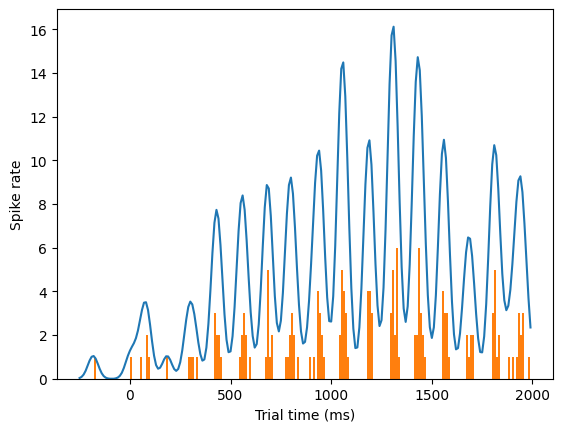

In [48]:
TFs = [1.0, 2.0, 4.0, 8.0, 15.0]
samp_interval = 10
trial_len_ms = 2000
prestim_len_ms = 250

tf = 8.0
di = 5
uid = list(allData.keys())[0]
ts = np.arange(-prestim_len_ms, trial_len_ms, samp_interval) # time bins
plt.plot(ts, allData[uid][tf]['psts'][di])
spike_ts = np.concatenate(allData[uid][tf]['n_trials'][di]) # concatenate all trials together
plt.hist(spike_ts-prestim_len_ms, ts)
plt.xlabel('Trial time (ms)')
plt.ylabel('Spike rate')
plt.show()

### Plot response map (combined PSTHs for all directions) for each temporal freq. (TF)

In [54]:
def showResponseMap(all_ISJs, trial_len_ms, prestim_len_ms, samp_interval, 
                    NDIRS=8, tick_interval_ms=250, f_ax=None):
    f, ax = plt.subplots(1,1) if f_ax is None else f_ax

    ax.imshow(all_ISJs, cmap='hot', aspect=8)
    ax.set(xticks=range(0,all_ISJs.shape[1],tick_interval_ms//samp_interval),yticks=range(NDIRS), yticklabels=['' for _ in range(NDIRS)],
                  xticklabels=np.arange(-prestim_len_ms,trial_len_ms,tick_interval_ms, dtype='int'))
    ax.set_ylabel('direction', size=8)
    dirs = np.arange(0,360,360//NDIRS)
    ax.set(yticks=range(len(dirs)), yticklabels=list(map(str,map(int,dirs))))
    ax.set_xlabel('trial time (ms)', size=8)
    ax.tick_params(labelsize=8)
    
    if f_ax is None:
        f.tight_layout()
    return f, ax

In [ ]:
# load pre-computed data from a specific AREA / session / kernel bandwidth
session_id = 719161530
AREA = 'VISp'
STIM_CLASS = 'drifting_gratings'
datadir = 'data'
bw = 25
fname = f's{session_id}_{AREA}_{STIM_CLASS}_bw{bw}'
with open(f'{datadir}/{fname}.pkl', 'rb') as f:
    allData = pickle.load(f)

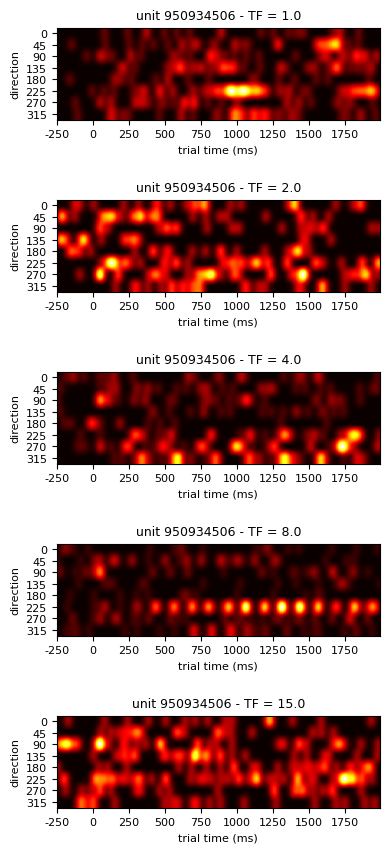

In [56]:
trial_len_ms = 2000
prestim_len_ms = 250
dirs = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]

uid = list(allData.keys())[0]

samp_interval = 10
NDIRS = 8
TFs = [1.0, 2.0, 4.0, 8.0, 15.0]
tick_interval_ms = 250

f, axes = plt.subplots(len(TFs),1,figsize=(4,1.75*len(TFs)))
for ax,tf in zip(axes,TFs):
    all_ISJs = allData[uid][tf]['psts']
    _, _ = showResponseMap(all_ISJs, trial_len_ms, prestim_len_ms, samp_interval,f_ax=(f,ax))
    ax.set_title(f'unit {uid} - TF = {tf}', size=9)
    ax.tick_params(labelsize=8)
f.tight_layout()
plt.show()